# Packages & Functions

## Packages

In [2]:
import random

import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Functions

In [3]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z]

In [4]:
def scailing(x, y):

    ms = MinMaxScaler()
    ss = StandardScaler()

    x_ss = ss.fit_transform(x)
    y_ms = ms.fit_transform(y)

    return x_ss, y_ms

In [5]:
def window_sliding(x, y, iw, ow):
    
    x_ws, y_ws = list(), list()
    for i in range(len(df)):
        x_end = i + iw
        y_end = x_end + ow
        
        if y_end > len(df):
            break
        
        tx = x[i:x_end, :]
        ty = y[x_end:y_end, :]
        
        x_ws.append(tx)
        y_ws.append(ty)
    
    return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device)

In [6]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [7]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
      
    total = train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()


# Data Processing

## Load Data

In [8]:
data = pd.read_csv('../../Data/CleanedData/서울_Cleaned.csv')
print(data.dtypes)

Unnamed: 0        int64
deathCnt          int64
defCnt            int64
gubun            object
gubunEn          object
incDec            int64
isolClearCnt      int64
isolIngCnt        int64
localOccCnt       int64
overFlowCnt       int64
qurRate         float64
stdDay           object
dtype: object


## Index & Col

In [9]:
df = data.loc[:, ['stdDay', 'defCnt']]
df.rename(columns = {'defCnt':'ACC', 'stdDay':'Date'}, inplace = True)
df['AC'] = df['ACC'] - df['ACC'].shift(1)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.loc[:, ['AC', 'DAC', 'DDAC']]

In [10]:
df.head()

,AC,DAC,DDAC
Date,,,
2020-01-20,NaN,NaN,NaN
2020-01-21,0.0,NaN,NaN
2020-01-22,0.0,0.0,NaN
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0


,Unnamed: 0,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20
1,1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21
2,2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22
3,3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23
4,4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24


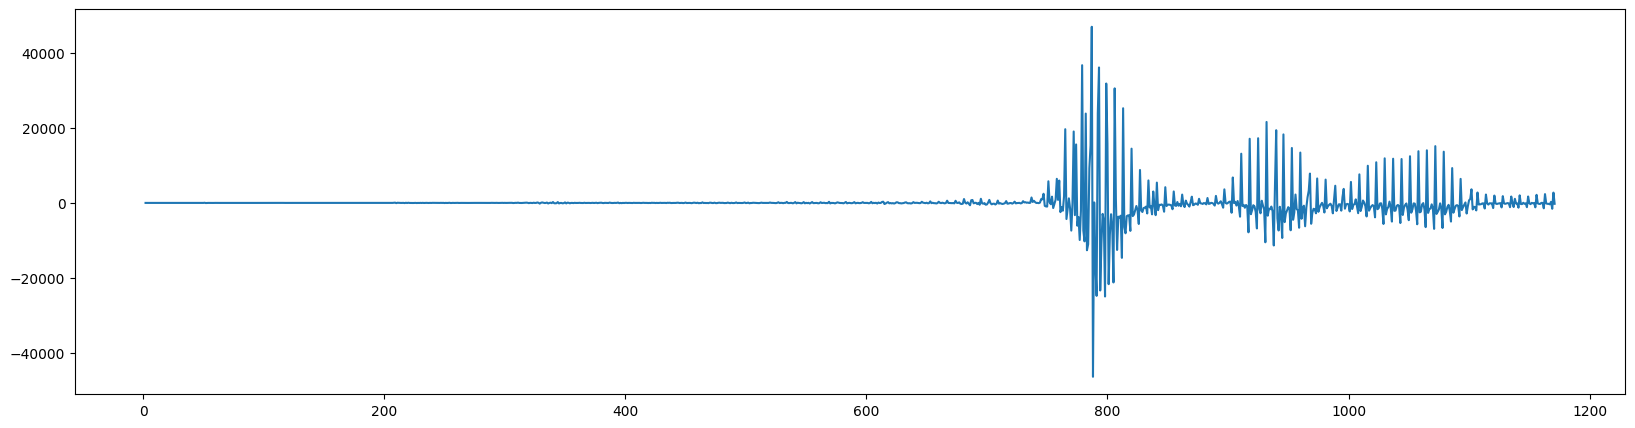

In [11]:
plt.figure(figsize=(20,5))
plt.plot(range(len(df)), df["DAC"])
data.head()

## Outlier Values

In [12]:
df.describe()

,AC,DAC,DDAC
count,1171.000000,1170.000000,1169.000000
mean,5124.964987,2.865812,-0.201027
std,12307.605125,4482.294851,7060.800099
min,0.000000,-46374.000000,-93354.000000
25%,98.500000,-194.500000,-76.000000
50%,522.000000,-7.000000,1.000000
75%,3929.500000,10.000000,84.000000
max,128371.000000,46980.000000,56804.000000


In [13]:
outlier_list = outlier(df, 'DAC', 1.58)

outlier_list

,AC,DAC,DDAC
Date,,,
2022-02-23,41465.0,19659.0,17868.0
2022-02-28,27971.0,-7380.0,-5902.0
2022-03-02,46933.0,19048.0,19134.0
2022-03-04,59269.0,15594.0,18852.0
2022-03-07,39558.0,-9891.0,-6147.0
...,...,...,...
2022-12-13,17696.0,13786.0,19479.0
2022-12-20,18223.0,14032.0,20490.0
2022-12-27,18725.0,15140.0,22063.0


## Null Values

In [14]:
df.isnull().sum()

AC      1
DAC     2
DDAC    3
dtype: int64

In [15]:
df.dropna(inplace = True)
df.head()

,AC,DAC,DDAC
Date,,,
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0
2020-01-25,0.0,-1.0,-2.0
2020-01-26,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0


,AC,DAC,DDAC
Date,,,
2020-01-23,0.0,0.0,0.0
2020-01-24,1.0,1.0,1.0
2020-01-25,0.0,-1.0,-2.0
2020-01-26,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0


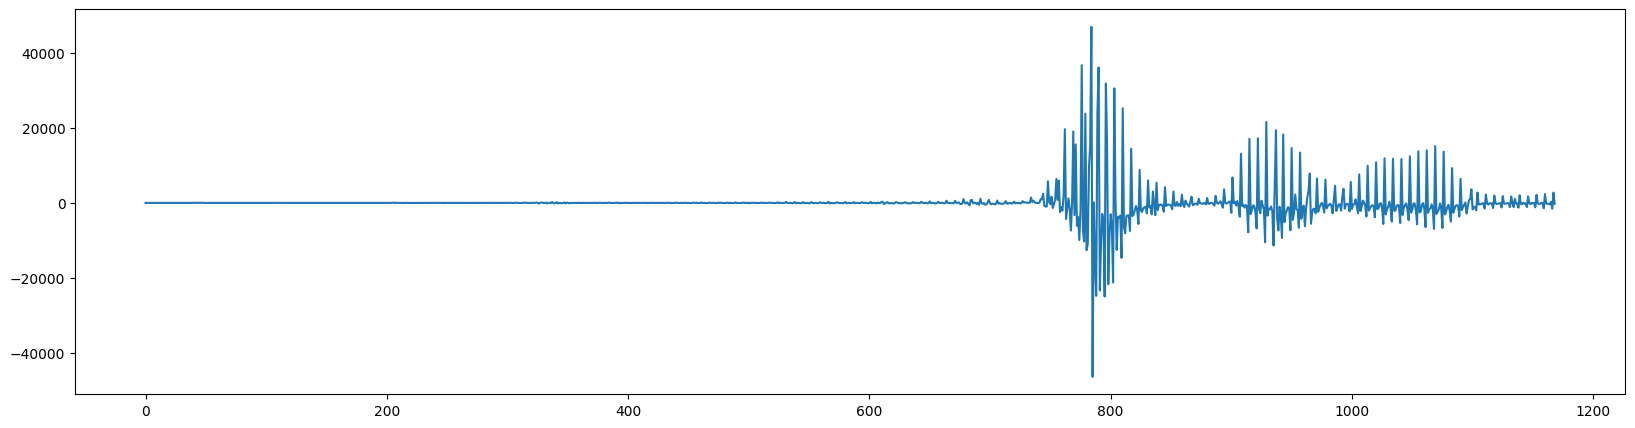

In [16]:
plt.figure(figsize=(20,5))
plt.plot(range(len(df)), df["DAC"])
df.head()

## Split Target

In [17]:
x = df.iloc[:, 0:]
y = df.iloc[:,:1]
print(x.head())
print(y.head())

             AC  DAC  DDAC
Date                      
2020-01-23  0.0  0.0   0.0
2020-01-24  1.0  1.0   1.0
2020-01-25  0.0 -1.0  -2.0
2020-01-26  0.0  0.0   1.0
2020-01-27  0.0  0.0   0.0
             AC
Date           
2020-01-23  0.0
2020-01-24  1.0
2020-01-25  0.0
2020-01-26  0.0
2020-01-27  0.0


## Scailing

In [18]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

In [19]:
print(x_ss[:5])
print()
print(y_ms[:5])

[[-4.17002386e-01 -6.39909593e-04  2.84829698e-05]
 [-4.16921158e-01 -4.16809589e-04  1.70170594e-04]
 [-4.17002386e-01 -8.63009597e-04 -2.54892278e-04]
 [-4.17002386e-01 -6.39909593e-04  1.70170594e-04]
 [-4.17002386e-01 -6.39909593e-04  2.84829698e-05]]

[[0.0000000e+00]
 [7.7899214e-06]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]


## Window Slide

In [20]:
x = x.to_numpy()
y = y.to_numpy()
x, y = window_sliding(x, y, 60, 7)
x_ss, y_ms = window_sliding(x_ss, y_ms, 60, 7)

## Split Train & Test

In [21]:
x_train = x_ss[:800]
y_train = y_ms[:800]
x_test = x_ss[800:]
y_test = y_ms[800:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([800, 60, 3])
torch.Size([800, 7, 1])
torch.Size([303, 60, 3])
torch.Size([303, 7, 1])


## Data Loader

In [22]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

# Model

## Define Model1

In [23]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device):
        super(encoder, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size = input_size, 
                          hidden_size = hidden_size, 
                          num_layers = num_layers, 
                          batch_first=True, 
                          dropout = 0.3)
        
    def forward(self, x):
        #print('Encoder')
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        #print("input_size: ", x.shape)
        out, hn = self.gru(x, h0)
        #print("out_size: ", out.shape)
        #print("hidden_size: ", hn[0].shape)
        
        return out, hn

In [24]:
class decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device):
        super(decoder, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          batch_first = True,
                          dropout = 0.3)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hn):
        #print('Decoder')
        #print("x_size: ", x.shape)
        x = x.unsqueeze(1)
        #print("x_input_size: ", x_input.shape)
        out, hn = self.gru(x, hn)
        #print("out_size: ", out.shape)
        #print("hn_size: ", hn[0].shape)
        out = self.linear(out)
        #print("out_size: ", out.shape)
        
        return out, hn

In [25]:
class encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, device):
        super(encoder_decoder, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = encoder(input_size = input_size, 
                               hidden_size = hidden_size,
                               num_layers = num_layers,
                               dropout = 0.3,
                               device = device)
        
        self.decoder = decoder(input_size = input_size, 
                               hidden_size = hidden_size,
                               num_layers = num_layers,
                               dropout = 0.3,
                               device = device)

    def forward(self, x, y, target_len, teacher_forcing_ratio):
        batch_size = x.shape[0]
        input_size = x.shape[2]
        #print("x_size: ", x.shape)
        outputs = torch.zeros(batch_size, target_len, 1)
        #print("y_size: ", y.shape)
        #print('')
        
        #print("Encoding")
        _, hn = self.encoder(x)
        #print("_ size: ", _.shape)
        #print("hidden_size: ", hn[0].shape)
        decoder_input = x[:,-1, :]
        #print("decoder_input_size: ", decoder_input.shape)
        #print('')
        
        #print('Decoding')
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hn = self.decoder(decoder_input, hn)
            #print("out_size: ", out.shape)
            out =  out.squeeze(1)
            #print("out_size: ", out.shape)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_output = y[:, t, :]
            else:
                decoder_output = out
            #print("out_size: ", out.shape)
            outputs[:,t,:] = out
            
            decoder_sub = torch.zeros(decoder_input.shape).to(device)
            
            decoder_sub[:, 0] = decoder_output[:, 0]
            decoder_sub[:, 1] = decoder_input[:, 0] - decoder_sub[:, 0]
            decoder_sub[:, 2] = decoder_input[:, 1] - decoder_sub[:, 1]
            decoder_input = decoder_sub

        return outputs

In [26]:
input_size = 3
hidden_size = 16
num_layers = 1


model = encoder_decoder(input_size = input_size, 
                        hidden_size = hidden_size,
                        dropout = 0.25,
                        device = device).to(device)

def criterion(actual, predict):
    
    loss = 0
    div = 0
    
    for i in range(7):
        div += (i+1)**2
    
    for i in range(32):
        
        for j in range(7):
            loss += ((j+1)**2) * ((actual[i][j] - predict[i][j])**2)
            
        loss /= div
    
    loss /= 32
        
    return loss

#criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 10000
optimizer = Adam(model.parameters(), lr = lr)
patience = 10

In [27]:
loss_list = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        seq, target = data
        out = model(seq, target, 7, 0.5).to(device)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss/n)
    if (epoch+1) % 100 == 0:
        print('epoch: %d loss: %.6f'%(epoch+1, running_loss/n))
        
    if (epoch % patience == 0) & (epoch != 0):
            
            if loss_list[epoch-patience] < loss_list[epoch]:
                print('\n Early Stopping / epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
                
                break

epoch: 100 loss: 0.000002

 Early Stopping / epoch: 151 loss: 0.0000


## Visualize Loss Graph

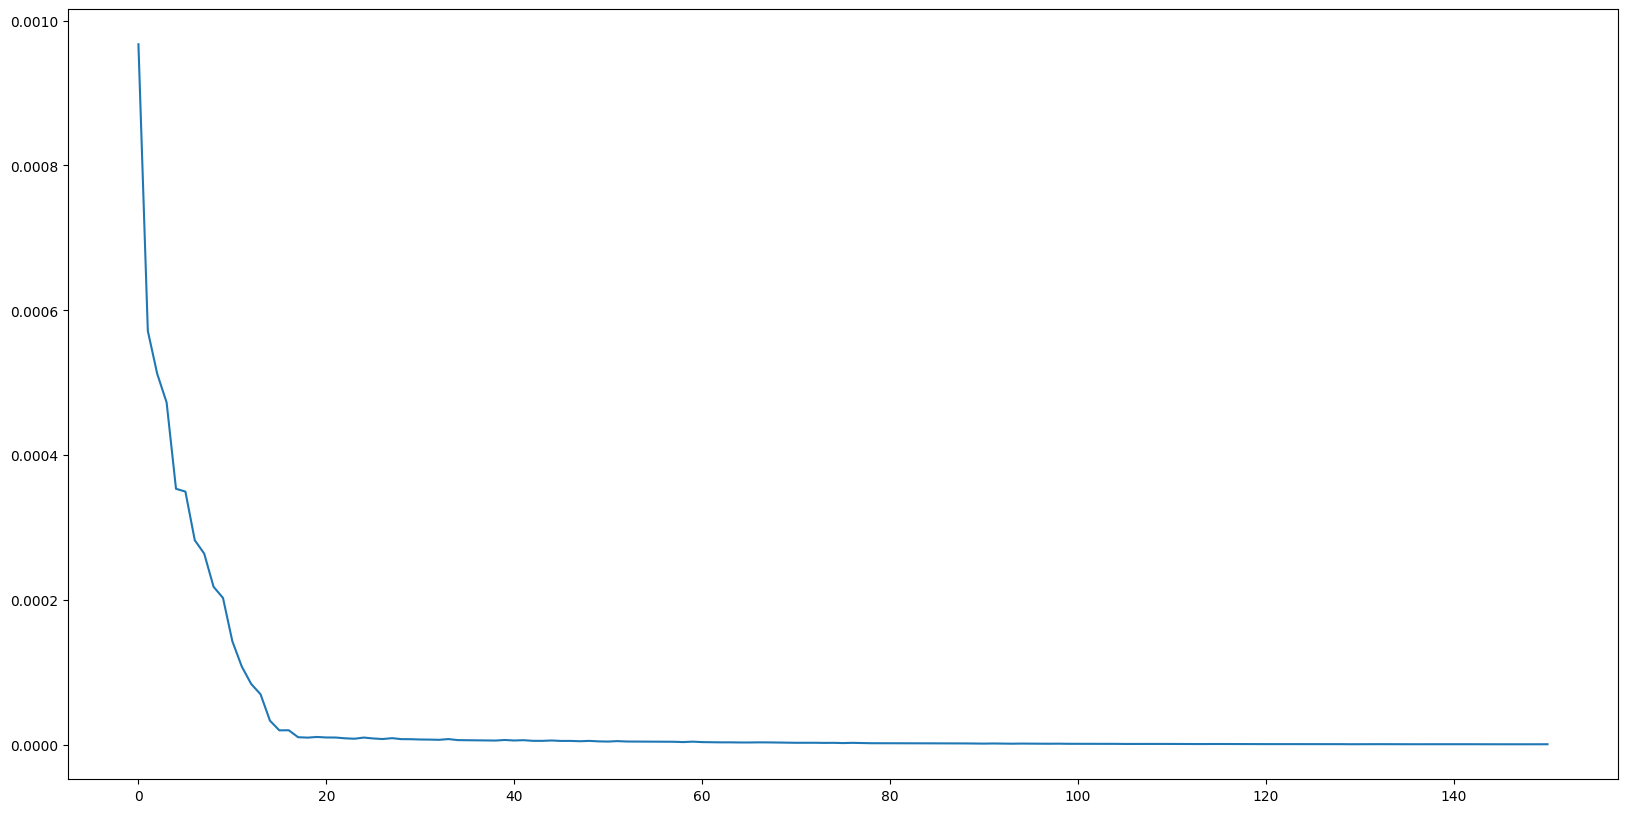

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(loss_list)
plt.show()

## Model Save and Load

In [22]:
PATH = "../../model/GRU_seq2seq2.pth"
torch.save(model.state_dict(), PATH)

In [23]:
PATH = "../../model/GRU_seq2seq2.pth"
model = encoder_decoder(input_size = input_size, 
                             hidden_size = hidden_size,
                             dropout = 0.25,
                             device = device).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

encoder_decoder(
  (encoder): encoder(
    (gru): GRU(3, 16, batch_first=True, dropout=0.3)
  )
  (decoder): decoder(
    (gru): GRU(3, 16, batch_first=True, dropout=0.3)
    (linear): Linear(in_features=16, out_features=1, bias=True)
  )
)

## Visualize and Compare predicted values with actual values

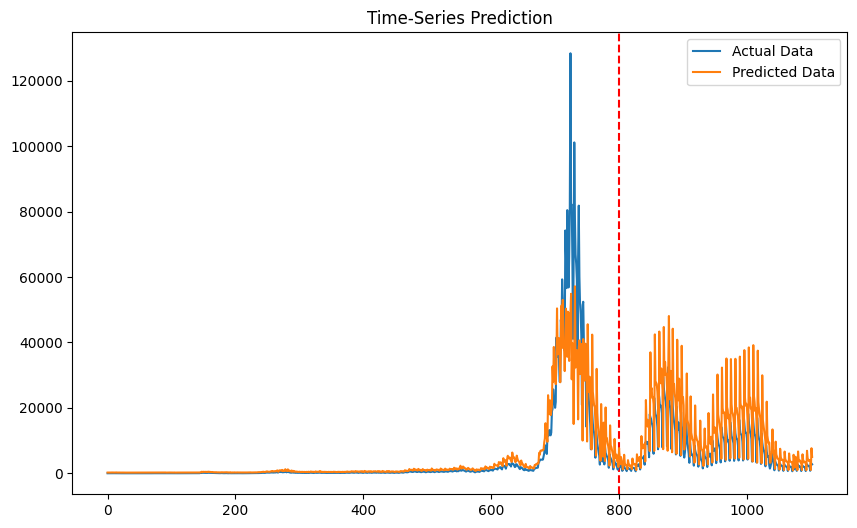

In [29]:
train_predict = model(x_ss, y_ms, 7, 0.5)
predicted = train_predict.cpu().data.numpy()
label_y = y_ms.cpu().data.numpy()

# 시각화를 위해 첫 날 예측값만을 가져옴
# 더 나은 방법이 있다면 수용할 필요가 있음
first_predicted = predicted[:, 0, :].reshape(1103, 1)
first_label_y = label_y[:, 0, :].reshape(1103, 1)

first_predicted = ms.inverse_transform(first_predicted)
first_label_y = ms.inverse_transform(first_label_y)

plt.figure(figsize = (10, 6))
plt.axvline(x = 800, c = 'r', linestyle = '--')

plt.plot(first_label_y, label = 'Actual Data')
plt.plot(first_predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Caculate MAE

In [30]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))
def RMSE(true, pred):
    return np.mean((true-pred)**2)**(1/2)
def MAPE(true, pred):
    return 100 * np.mean(np.abs((true-pred)/true))

print('MAE SCORE : ', MAE(predicted, label_y))
print('RMSE SCORE : ', RMSE(predicted, label_y))
print('MAPE SCORE : ', MAPE(predicted, label_y))

MAE SCORE :  0.025778426
RMSE SCORE :  0.06002286297842086
MAPE SCORE :  78.96360754966736


# Predict

In [42]:
ran = random.randrange(600, 899)
ran

717

In [43]:
pre7 = ms.inverse_transform(predicted.reshape(881, 7))
lab7 = ms.inverse_transform(label_y.reshape(881, 7))

predicted_final = np.vstack((first_predicted[:ran], pre7[ran].reshape(7, 1)))
label_y_final = np.vstack((first_label_y[:ran], lab7[ran].reshape(7, 1)))

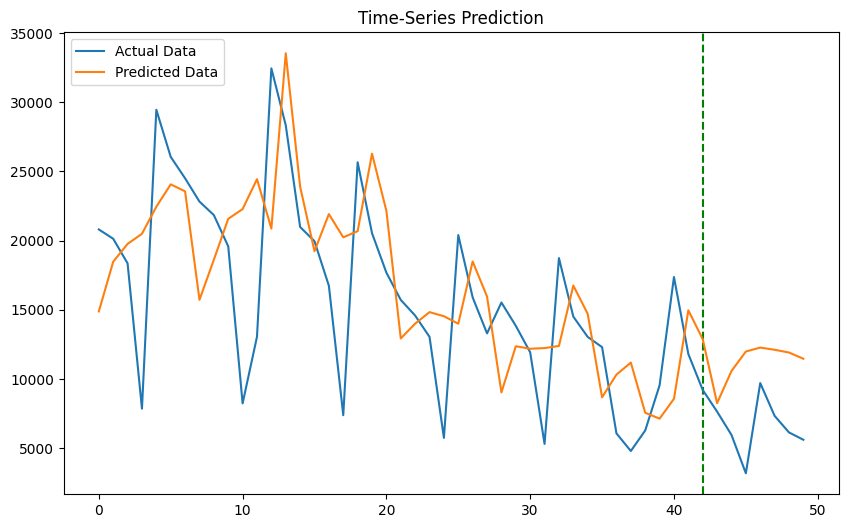

In [44]:
plt.figure(figsize = (10, 6)) 
plt.axvline(x = 42, c = 'g', linestyle = '--')

plt.plot(label_y_final[-50:], label = 'Actual Data')
plt.plot(predicted_final[-50:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

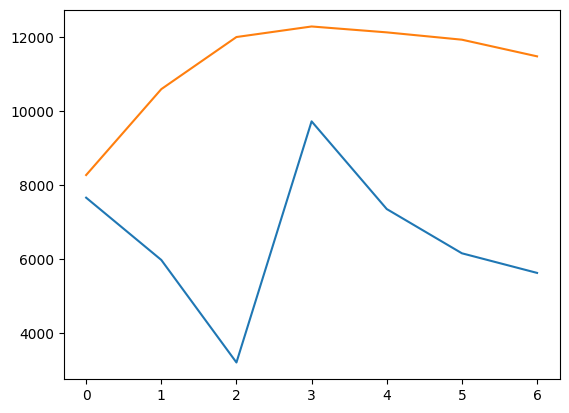

In [45]:
plt.plot(lab7[ran], label = 'Actual Data')
plt.plot(pre7[ran], label = 'Predicted Data')
plt.show()